### Here we study the photometry noise based on the GAMA catalog

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import torch
import corner
import os

In [3]:
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.utils import flux2mag, mag2flux, sigma_flux2mag, sigma_mag2flux

In [5]:
# gama_cat = Table.read('./reference_catalog/GAMA/gama_spec_photometry_z_mass.fits')
# gama_cat = Table.read('./reference_catalog/GAMA/gkvPhotStellarMass.fits')
gama_cat = Table.read('./reference_catalog/GAMA/LambdarPhotStellarMass.fits')

In [6]:
filters = list('ugrizYJHK')

In [31]:
fluxes = np.vstack([gama_cat[f'{filt}_flux'].data for filt in list('ugrizYJHK')]).T
fluxes_err = np.vstack([gama_cat[f'{filt}_fluxerr'].data for filt in list('ugrizYJHK')]).T
mags = 8.9 - 2.5 * np.log10(fluxes)

In [32]:
flag = np.all((mags != 99.0), axis=1) & np.all((mags != -9999.0), axis=1) & np.all((mags != -99.0), axis=1) 
flag &= (mags[:, 2] < 19.65) & ((mags[:, 6] - mags[:, 8]) > 0.025)# & (mags[:, 1] < 24) & (mags[:, 3] < 24)
flag &= (gama_cat['Z'] < 1) & (gama_cat['Z'] > 0)
flag &= (~np.any(np.isnan(mags), axis=1)) & (~np.any(np.isinf(mags), axis=1)) & (np.all(mags > 0, axis=1))
flag &= (gama_cat['logmstar'] > 7)

In [33]:
gama_cat = gama_cat[flag]

In [34]:
len(gama_cat)

132279

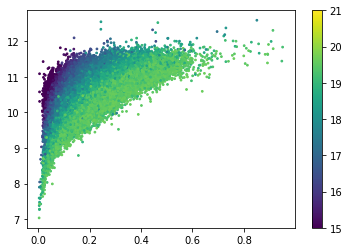

In [35]:
plt.scatter(gama_cat['Z'], gama_cat['logmintsfh'], c=mags[flag][:, 2], 
            s=3, vmin=15, vmax=21)
plt.colorbar()

# plt.xlim(0, 0.2)
# plt.ylim(7, 12)

(8.0, 12.5)

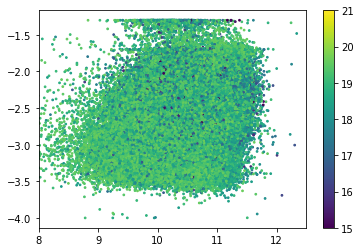

In [20]:
plt.scatter(gama_cat['logmstar'], gama_cat['logmet'], c=mags[flag][:, 2],
            s=3, vmin=15, vmax=21)
plt.colorbar()

plt.xlim(8, 12.5)

In [21]:
z_mass_met = np.vstack([gama_cat['Z'], gama_cat['logmintsfh'], gama_cat['logmet'] - np.log10(0.0190)]).T

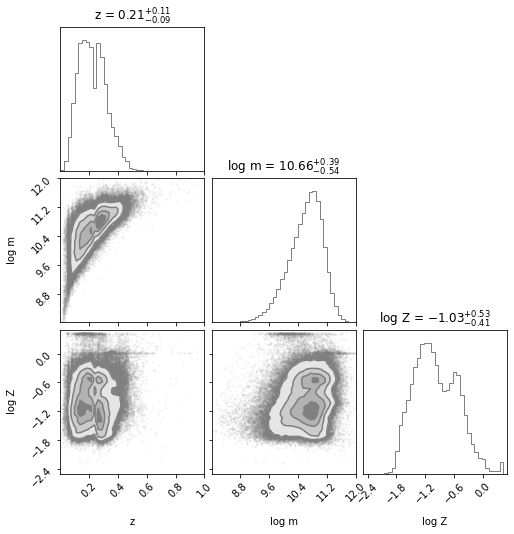

In [22]:
figure = corner.corner(z_mass_met, 
#                        fig=figure,
                  labels=['z', 'log m', 'log Z'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                       range=[[0, 1], [8, 12], [-2.5, 0.5]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

In [36]:
mags = mags[flag]
fluxes = fluxes[flag]
fluxes_err = fluxes_err[flag]
# sigs = mags_err[flag] # sigma of magnitude

In [37]:
np.save('./reference_catalog/GAMA/gama_clean_mag_lambdar.npy', mags)

In [38]:
np.save('./reference_catalog/GAMA/gama_clean_z_mass_lambdar.npy', 
        np.vstack([gama_cat['Z'], gama_cat['logmintsfh']]).T)

---

### Noise model

`sigs` is defined as $\Delta f/ f$ or $\Delta m / m$

In [39]:
sigs = sigma_flux2mag(fluxes_err, fluxes)

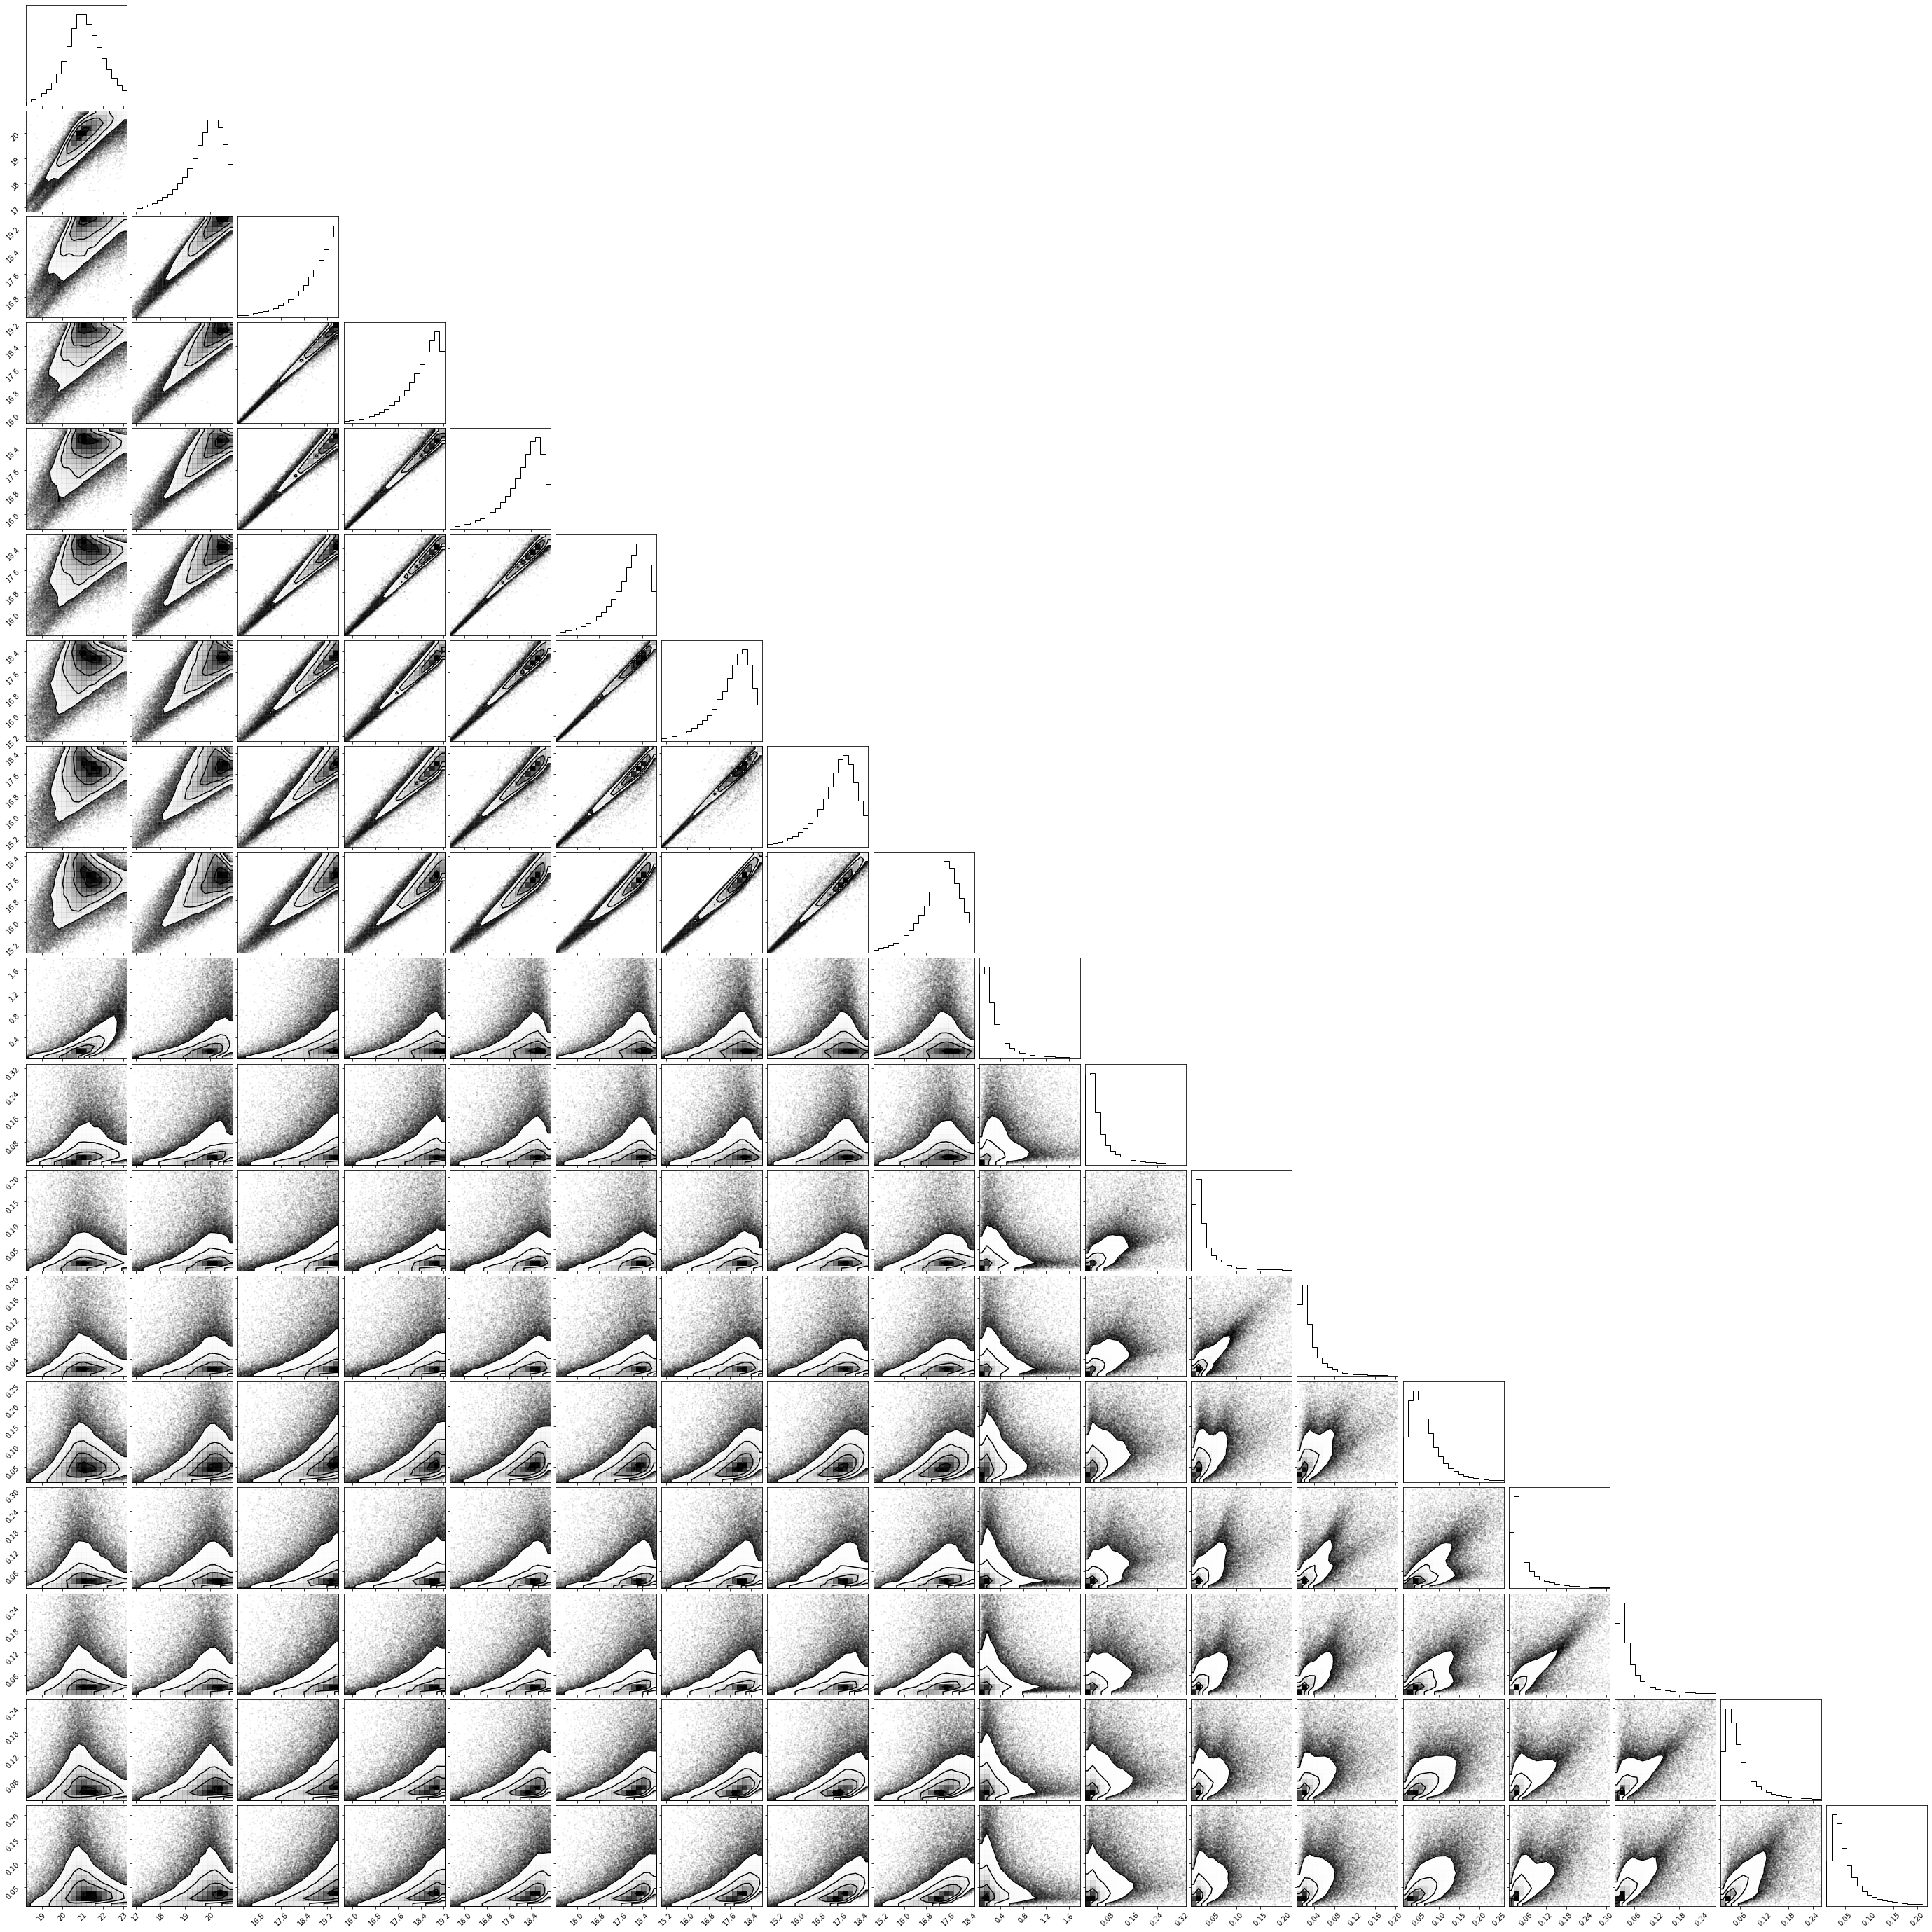

In [42]:
fig = corner.corner(np.concatenate([mags, sigs], axis=1), 
                    range=np.nanquantile(
                     np.concatenate([mags, sigs], axis=1), 
                     [0.01, 0.95], axis=0).T) 

In [43]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [44]:
def trimmed_median(x): 
    xlim = np.quantile(x, [0.0, 0.99])
    return np.median(x[(x > xlim[0]) & (x < xlim[1])])

def trimmed_std(x): 
    xlim = np.quantile(x, [0.0, 0.99])
    return np.std(x[(x > xlim[0]) & (x < xlim[1])])

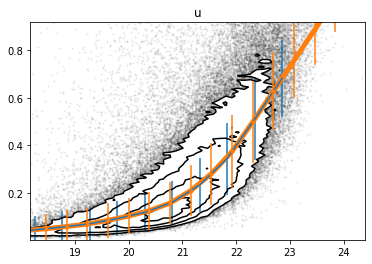

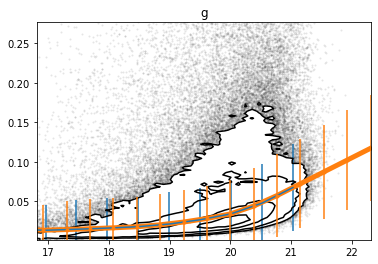

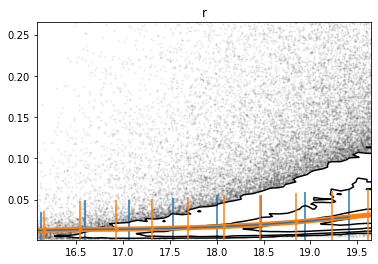

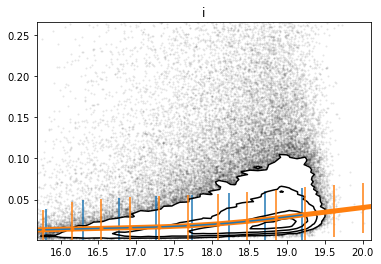

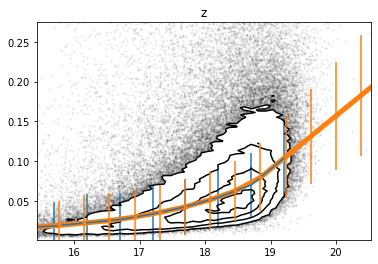

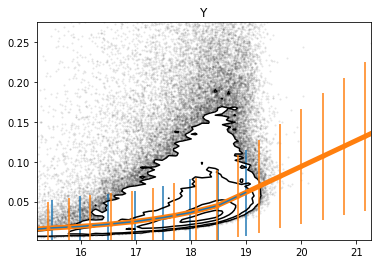

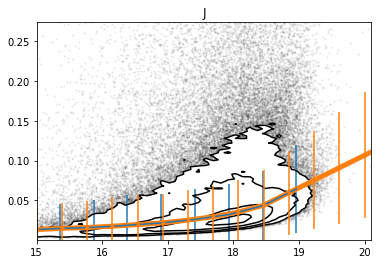

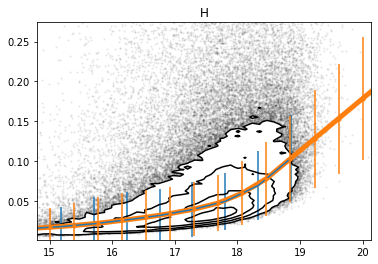

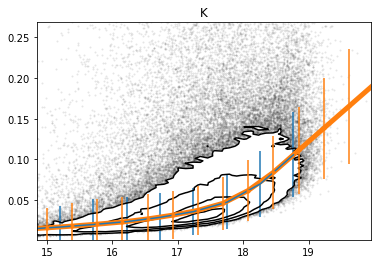

In [45]:
meds_sigs, stds_sigs = [], [] 

# for i in range(len(filters)): 
for i in range(len(filters)): 
    clean = (np.isfinite(mags[:,i]) & (sigs[:,i] < np.max([np.quantile(sigs[:,i], 0.9), 0.3])))

    med_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_median, 
                                              range=np.nanquantile(mags[clean,i], [0., 0.995]), bins=20)
    std_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_std, 
                                              range=np.nanquantile(mags[clean,i], [0., 0.995]), bins=20)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], 
                              fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], 
                              fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    corner.hist2d(mags[clean,i], sigs[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 25, 40)), fmt='.C1')
    sub.set_xlim(np.nanquantile(mags[clean,i], [0.01, 1.]))
    sub.set_ylim(np.nanquantile(sigs[clean,i], [0.0, 0.995]))
    
    sub.set_title(filters[i])

In [211]:
np.save('./noise_model/gama_noise_model_mag_lambdar.npy', np.vstack([meds_sigs, stds_sigs]))